<a href="https://colab.research.google.com/github/Carnoustie/DeepLearningClassKTH/blob/main/WideResnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import datasets, layers, models, regularizers, preprocessing, optimizers,Model, Input
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, Flatten, Conv2D, Lambda,	Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 22 14:50:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(trainX,trainLabels), (testX,testLabels) = datasets.cifar10.load_data()

#Map pixel values from [0, 255}  to -> [0, 1]
#trainX, testX = trainX/255.0 , testX/255.0

#testLabels = to_categorical(testlabels)


trainMean = np.mean(trainX,0)
trainDev = np.std(trainX,0)
trainX = trainX-trainMean
trainX = trainX/trainDev

testX = testX-trainMean
testX = testX/trainDev


print("Sanity Check:\n\nmean ", np.mean(trainX),  "\n\nvar: ", np.std(trainX))



170498071/170498071 [==============================] - 13s 0us/step
Sanity Check:

mean  7.94919685631612e-18 

var:  0.9999999999999998


In [ ]:
trainLabels = tf.keras.utils.to_categorical(trainLabels)
testLabels = tf.keras.utils.to_categorical(testLabels)




In [ ]:

num_classes = 10
input_shape = (32,32,3)
model_input = Input(shape=input_shape)

weightDecay = regularizers.L2(0.0005)

k=3;

def stack(input, filter,n,k):

    x = input
    if(filter==16):
      xx = layers.Conv2D(filter*k, (3,3),  strides=(1, 1),padding='same', kernel_initializer='he_normal')(x)
      xx = layers.BatchNormalization(axis=3)(xx)
      xx = layers.Activation('relu')(xx)
      xx= layers.Dropout(0.2)(xx)
      xx = layers.Conv2D(filter*k, (3,3),  strides=(1, 1),padding='same', kernel_initializer='he_normal')(xx)
      xx = layers.BatchNormalization(axis=3)(xx)
      x = layers.Add()([xx,x]);
      x = layers.Activation('relu')(x)
    else:
      xx = layers.Conv2D(filter*k, (3,3),  strides=(2, 2),padding='same', kernel_initializer='he_normal')(x)
      xx = layers.BatchNormalization(axis=3)(xx)
      xx = layers.Activation('relu')(xx)
      xx = layers.Dropout(0.2)(xx)
      xx = layers.Conv2D(filter*k, (3,3),  strides=(1, 1),padding='same', kernel_initializer='he_normal')(xx)
      xx = layers.BatchNormalization(axis=3)(xx)
#      x = layers.Conv2D(32, (1,1), strides=(2, 2))(x)
      x = layers.Lambda(lambda x: tf.pad(x[:, ::2, ::2, :], tf.constant([[0, 0,], [0, 0], [0, 0], [filter*k//4, filter*k//4]]), mode="CONSTANT"))(input)
      x = layers.Add()([xx,x])
      x = layers.Activation('relu')(x)
    for i in range(1,n):
      xx = layers.Conv2D(filter*k, (3,3),  strides=(1, 1),padding='same', kernel_initializer='he_normal')(x)
      xx = layers.BatchNormalization(axis=3)(xx)
      xx = layers.Activation('relu')(xx)
      xx = layers.Dropout(0.2)(xx)
      xx = layers.Conv2D(filter*k, (3,3), strides=(1, 1),padding='same', kernel_initializer='he_normal')(x)
      xx = layers.BatchNormalization(axis=3)(xx)
      x = layers.Add()([xx,x])
      x = layers.Activation('relu')(x)
    return x


def resnet(model_input,n,width):
    
    x = layers.Conv2D(16*width, kernel_size = (3,3), kernel_initializer='he_normal', padding='same', strides=(1, 1))(model_input)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    for k in [16,32,64]:
      x = stack(x,k,n,width)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    #x = layers.Dense(units = 1000,activation ='relu')(x)
    x = layers.Dense(units = num_classes, activation ='softmax')(x)
    model = Model(inputs=model_input, outputs=x, name='ResNet')
    return model

#instantiate the model
#resNetModel = resnet(model_input,3)

#display model summary
#resNetModel.summary() 

In [ ]:
LearningRate = optimizers.schedules.CosineDecay(0.1, 100*trainX.shape[0],0.001)

# Learning rate config per the He et al. paper
boundaries = [32000, 48000]
values = [0.1, 0.01, 0.001]
lr_schedule = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer_momentum = 0.9
optimizer_additional_metrics = ["accuracy"]
opt = SGD(learning_rate=lr_schedule, momentum=optimizer_momentum)


#opt = SGD(LearningRate, momentum=0.9)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit(trainX, trainLabels, epochs=10, validation_data=(testX, testLabels))
generator = preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
batches = generator.flow(trainX, trainLabels, batch_size=64)

def trainModel(optimizer,model,numEpochs):
  model.compile(optimizer=opt,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(batches, steps_per_epoch=trainX.shape[0]/64,epochs=numEpochs,
                      validation_data=(testX, testLabels))
  historyTrain = history.history['accuracy']
  historyVal = history.history['val_accuracy']
  return historyTrain, historyVal

resnet14 = resnet(model_input,3,3)
# resnet32 = resnet(model_input,5)
# resnet44 = resnet(model_input,7)
#resnet56 = resnet(model_input,9)
# resnet110 = resnet(model_input,18)


resnet14.summary() 
#resnet44.summary() 
#resnet56.summary()
#resnet110.summary() 


trainHistory14, testHistory14 = trainModel(opt,resnet14,100)
#trainHistory32, testHistory32 = trainModel(opt,resnet32,100)
#trainHistory44, testHistory44 = trainModel(opt,resnet44,100)
#trainHistory56, testHistory56 = trainModel(opt,resnet56,120)
#trainHistory110, testHistory110 = trainModel(opt,resnet110,100)







Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 48)   1344        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 32, 32, 48)  192         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 32, 32, 48)   0           ['batch_normalization_20[0][

NameError: ignored

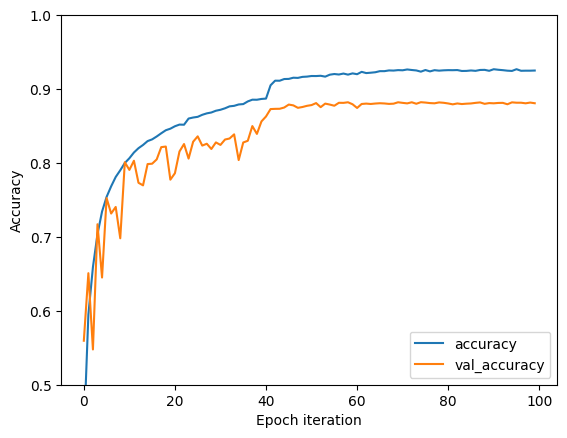

In [ ]:
#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
#plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(testX,  testLabels, verbose=2)
trainHistory,testHistory = trainHistory14,testHistory14 
plt.plot(trainHistory, label='accuracy')
plt.plot(testHistory, label='val_accuracy')
plt.xlabel('Epoch iteration')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('cifar100_resnet20')
testLoss, testAccuracy = resNetModel.evaluate(testX,testLabels, verbose=2)

In [ ]:
plt.plot(saveThickTrain, label='training error 37 layers')
plt.plot(backupVgg19Train, label='training error VGG-19 (19 layers)')
plt.xlabel('Epoch iteration')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('deep_shallow_Compare.png')
testLoss, testAccuracy = model.evaluate(testX,testLabels, verbose=2)